Imports and Setup

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Define model save directory and model name before training loop
model_save_dir = "trained_models"
os.makedirs(model_save_dir, exist_ok=True)

# Define model name (update this per model if looping through multiple)
model_name = 'mobilenetv3_large_100'  # <-- change as needed
model_path = os.path.join(model_save_dir, f"DMS_{model_name}.pth")


j:\DMS_Thesis_CNN_4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Define Dataset and Dataloaders

In [ ]:
# Paths to dataset
data_dir = r"J:\DMS_Thesis_CNN_4\DMS.v5i.tensorflow_cropped - Copy"
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir  = os.path.join(data_dir, 'test')

# Hyperparameters
batch_size = 16
num_epochs = 20
learning_rate = 1e-4

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

# Class info
class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)


Classes: ['drowsy', 'focused', 'holding phone', 'using-phone', 'yawning']


Define Training & Evaluation Functions

In [3]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

Initialize Model

In [4]:
# Set the model name here
model_name = 'mobilenetv3_large_100'  # Change this per model

# Create model
model = timm.create_model(model_name, pretrained=True)
model.reset_classifier(num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Directory to save models
model_save_dir = "trained_models"
os.makedirs(model_save_dir, exist_ok=True)

# Define dynamic model path based on model name
best_val_acc = 0.0
best_model_path = os.path.join(model_save_dir, f"DMS_{model_name}.pth")

# Initialize tracking lists
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []



Train the Model

In [5]:
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, valid_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Valid Loss: {val_loss:.4f}, Valid Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"  Best model saved to {best_model_path}!")



Epoch [1/20]
  Train Loss: 0.5187, Train Acc: 0.8020
  Valid Loss: 0.5803, Valid Acc: 0.8217
  Best model saved to trained_models\DMS_mobilenetv3_large_100.pth!
Epoch [2/20]
  Train Loss: 0.2142, Train Acc: 0.9169
  Valid Loss: 0.5548, Valid Acc: 0.8468
  Best model saved to trained_models\DMS_mobilenetv3_large_100.pth!
Epoch [3/20]
  Train Loss: 0.1296, Train Acc: 0.9494
  Valid Loss: 0.6465, Valid Acc: 0.8552
  Best model saved to trained_models\DMS_mobilenetv3_large_100.pth!
Epoch [4/20]
  Train Loss: 0.0800, Train Acc: 0.9718
  Valid Loss: 0.7596, Valid Acc: 0.8273
Epoch [5/20]
  Train Loss: 0.0572, Train Acc: 0.9791
  Valid Loss: 0.7973, Valid Acc: 0.8691
  Best model saved to trained_models\DMS_mobilenetv3_large_100.pth!
Epoch [6/20]
  Train Loss: 0.0391, Train Acc: 0.9870
  Valid Loss: 0.8346, Valid Acc: 0.8774
  Best model saved to trained_models\DMS_mobilenetv3_large_100.pth!
Epoch [7/20]
  Train Loss: 0.0296, Train Acc: 0.9906
  Valid Loss: 0.8654, Valid Acc: 0.8496
Epoch [8/

Plot Accuracy and Loss Curves

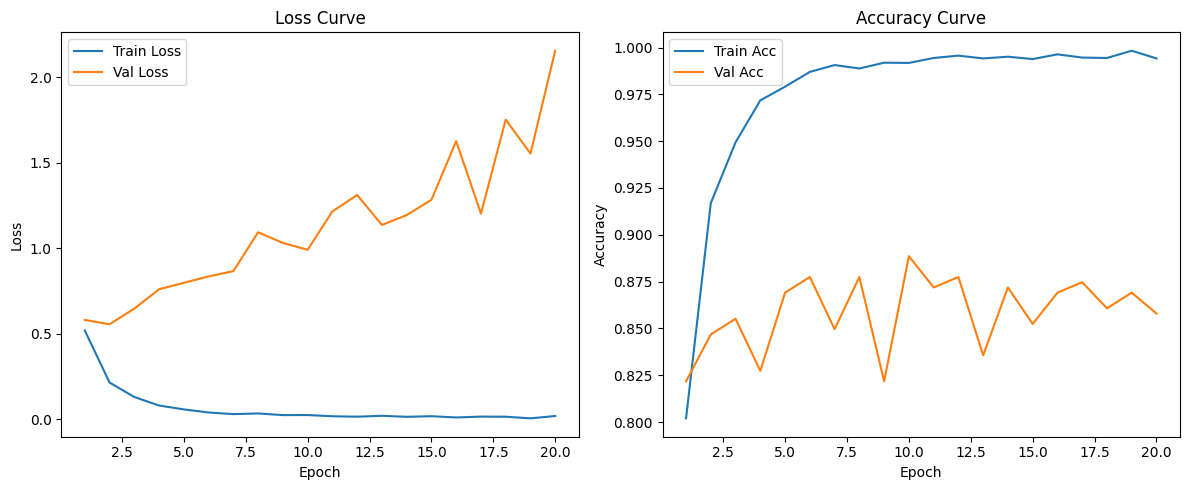

In [6]:
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Acc')
plt.plot(epochs_range, val_accuracies, label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Test Set Evaluation & Report

In [7]:
model.load_state_dict(torch.load(best_model_path))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 0.3920, Test Accuracy: 0.9151


Confusion Matrix and Classification Report

In [8]:
y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Confusion Matrix:
[[ 73  16   0   0   0]
 [  8 172   2   0   0]
 [  1   3  67   0   0]
 [  0   0   1   0   0]
 [  0   0   0   0  22]]

Classification Report:
               precision    recall  f1-score   support

       drowsy       0.89      0.82      0.85        89
      focused       0.90      0.95      0.92       182
holding phone       0.96      0.94      0.95        71
  using-phone       0.00      0.00      0.00         1
      yawning       1.00      1.00      1.00        22

     accuracy                           0.92       365
    macro avg       0.75      0.74      0.75       365
 weighted avg       0.91      0.92      0.91       365



j:\DMS_Thesis_CNN_4\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
j:\DMS_Thesis_CNN_4\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
j:\DMS_Thesis_CNN_4\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
